#### Steps:

1. Load data
2. See all columns and data types
- features or columns.describe
- Summarize numerical variables, summarizecatrgorical variables. See if we need to convert some numerical to categorical
4. Try to understand/get an intuition about data
- Decide on what questions you want to be answered through the Data: Use plots , bar graphs etc to get a sense. 
- Look at col names, data types, describe the main sale price col(see basic stats, skewness, kurtosis ,histogram etc).
- Look at scatter plots for categorical variables
- Find out how many unique categories each variable has
- Do encoding accordingly for the variables you want to use: Neighboorhood
- Select Correlation Matrix and select top N features
- See if you want to list 4-5 primary features to work on.
    * LotArea
    * BldgType          object
    * HouseStyle        object
    * OverallQual        int64
    * OverallCond        int64
    * YearBuilt
    * GrLivArea          int64
- 
5. Missing Values:
       - Find out how many missing values
       - Find out how to handle them. Drop/impute etc
       
6. Model Selection:
       - Linear Regression
       - Linear Regression with regularization
   
 7. Check for model assumptions and made necessary adjustments:
        - Normality
        - Homoskedasticity: To check this we will need to see the plot of residuals
        - Multicollinearity

    * The process followed here was as follows:
    * Checked for normality using 4 measures/plots: ## study these
      - Histogram of residuals
      - Scatter plot of fitted values/predicted values vs residuals: should be random
      - Q-Q Plot
      - Shapiro-Wilk p-value
    * Made some updates to feature and after each update checked for normality again using the above step. The updates were:
      - Remove outliers from GrLiving Area
      - Log transform to GrLiving Area
      - Outliers and handling 0 values for TotalBasementSF
      - Adding Neighborhood feature by encoding it
        
9. Divide dataset nto training and test
10. Train the model
11. Test on CV. Compare both loss functions.
12. See if we need to fine tune it. Check for Bias/Variance
13. Apply on test set.
14. Evaluate performance

15. Iteration 2- Could possible apply/deep dive into the following
                                                                            
- Check multicollinearity (e.g., using VIF)

- Use model-based selection methods, like:

- Lasso / Ridge regularization

- Recursive Feature Elimination (RFE)

- Feature importance from tree models

### The END

### Import Libraries and dataset


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.3f' % x)


In [2]:
# Load dataset and preview it
df_train=pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
print(df_train.shape)


(1460, 81)


Dataset has 1460 rows and 81 columns

### EDA: Initial Questions and Analysis: 

1. **Target Distribution & Outliers:**
- What does the distribution of SalePrice look like? Is it skewed?
- Are there outliers in SalePrice that could distort the model?

2. **Feature Relationships**
- Which features are most strongly correlated with SalePrice?
- Are there multicollinear features (e.g., GarageArea and GarageCars)?

3. **Categorical vs. Numerical**
- Which features are truly categorical vs. ordinal (e.g., OverallQual is technically numeric but ordered)?

4. **Missing Values**
   
6. **Feature Engineering**
- Create new features like: Age = YrSold - YearBuilt





In [4]:
# See all columns/features
pd.set_option('display.max_rows', None)
print(df_train.dtypes)

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1         int64
BsmtFinType2      object
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
Heating           object


In [5]:
# Summarize the Dependent variable: Sale Price
df_train['SalePrice'].describe()

count     1460.000
mean    180921.196
std      79442.503
min      34900.000
25%     129975.000
50%     163000.000
75%     214000.000
max     755000.000
Name: SalePrice, dtype: float64

<Axes: xlabel='SalePrice', ylabel='Density'>

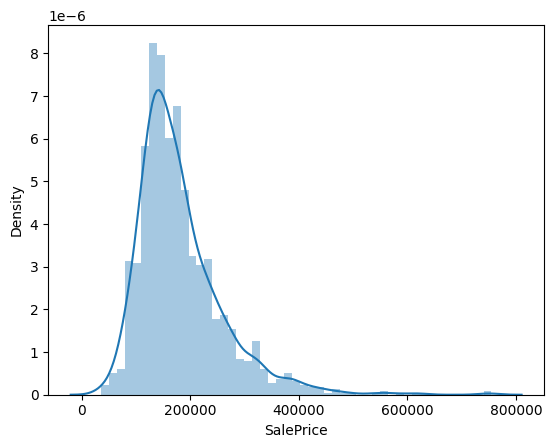

In [6]:
#histogram
sns.distplot(df_train['SalePrice'])

In [7]:
print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


In [8]:
df_train['price_per_sqft'] = df_train['SalePrice']/(df_train['GrLivArea']+df_train['TotalBsmtSF'])


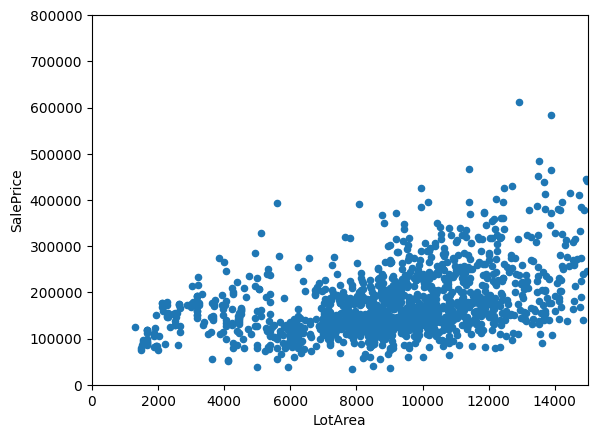

In [9]:
var = 'LotArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice' ,ylim=(0,800000),xlim=(0,15000));

Sale Price variable is skewed. We will need to apply transformation later. Now we will analyse other variables. We wish to get a sense of the relationship between sale price and what features impacts it. Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.




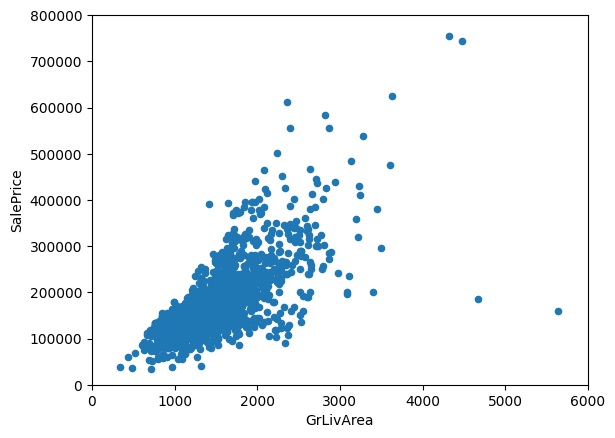

In [10]:
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice' ,ylim=(0,800000),xlim=(0,6000));

Larger the area higher the cost. We will remove some outliers as they don't make sense. Very high areas and low rpice

In [11]:
# Remove Outliers
df_train = df_train.drop(df_train[(df_train['GrLivArea']>4000) & (df_train['SalePrice']<300000)].index)


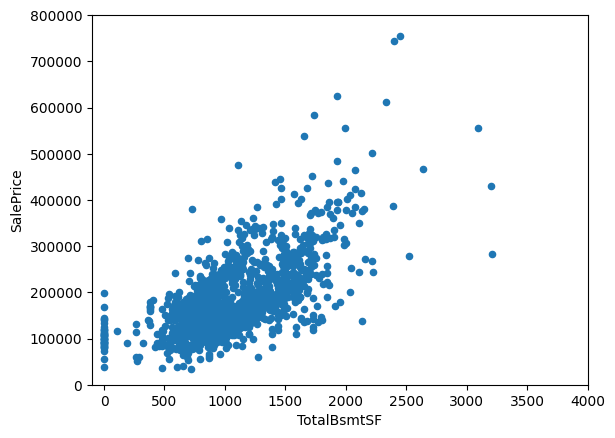

In [12]:
var='TotalBsmtSF'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice' ,ylim=(0,800000),xlim=(-100,4000));

Some 0 values and outliers. We wil need to deal with 0 values, outliers are still directionally okay so won;t make any changes there

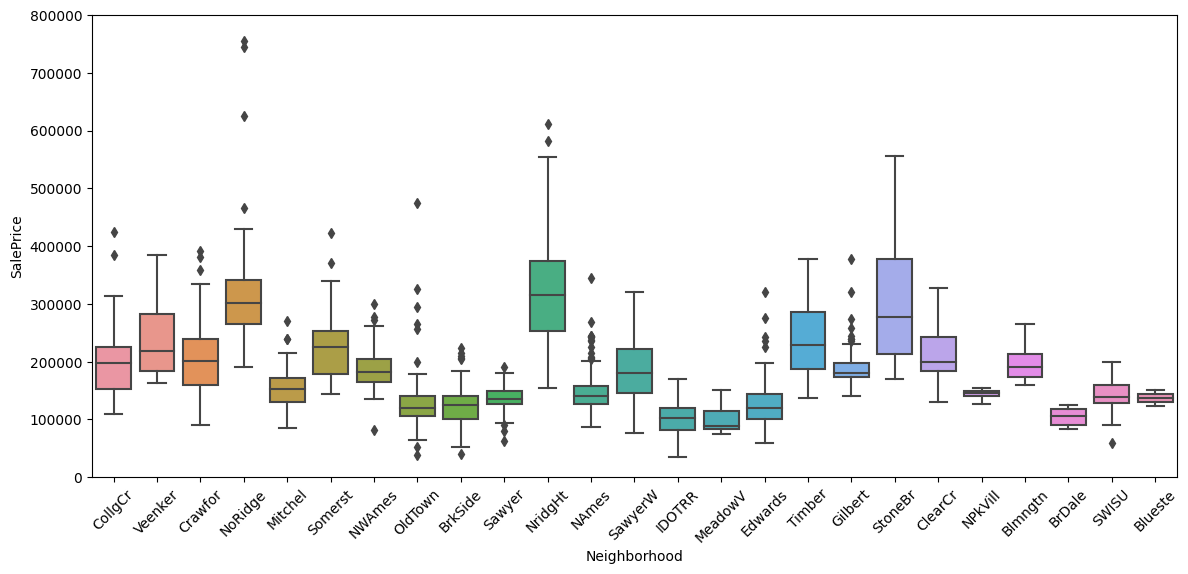

In [13]:
var = 'Neighborhood'
# var = 'OverallCond'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(14, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000)
plt.xticks(rotation = 45);

Some Neighborhoods like Veenker,NridgHT,StoneBr,Timber show a wider spread in prices probably because of greater variablilty of home size or features. Some Neighborhoods like NoRidge,Somerset,NAmes exhibit significant outliers,suggesting the presence of exceptionally priced properties or greater heterogenity. 

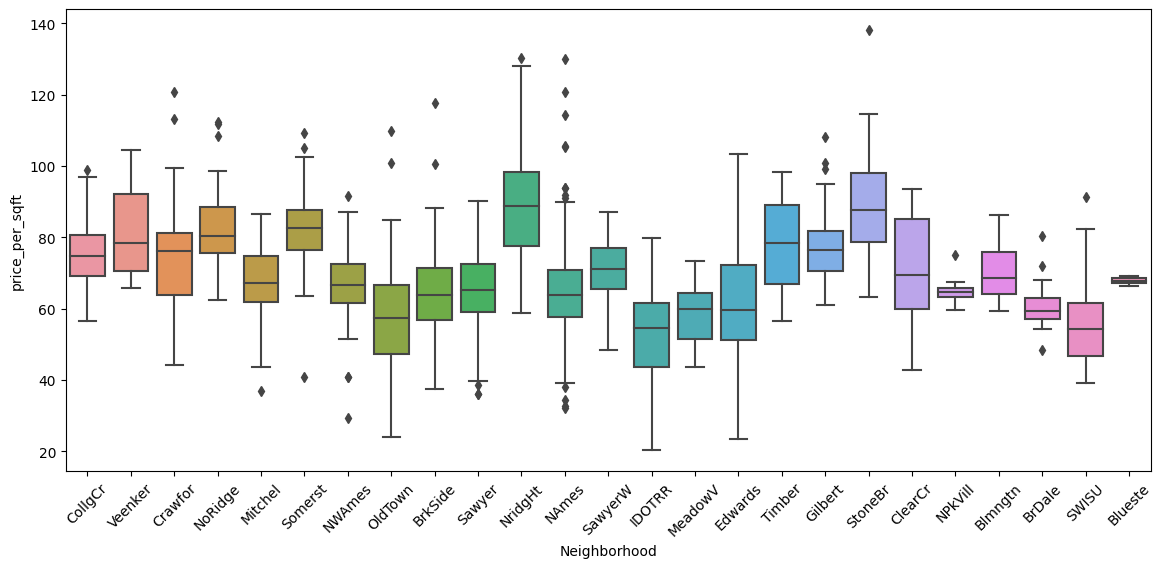

In [14]:
data = pd.concat([df_train['price_per_sqft'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(14, 6))
fig = sns.boxplot(x=var, y='price_per_sqft', data=data)
plt.xticks(rotation = 45);

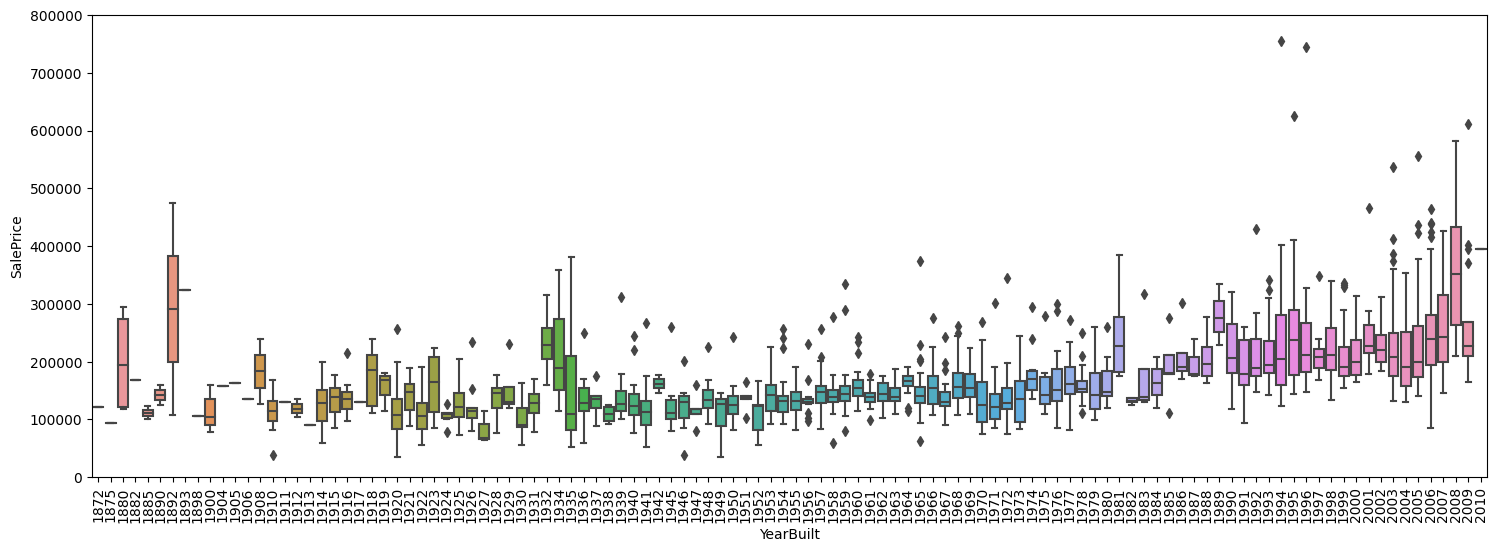

In [15]:
var = 'YearBuilt'
# var = 'OverallCond'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(18, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000)
plt.xticks(rotation = 90);

High variablility(wider boxes and outliers) in some years like 2006-2008 indicate a mix of home types and possible speculative pricing during the housing bubble period. Dip in 2009 aligns with the post crash correction.


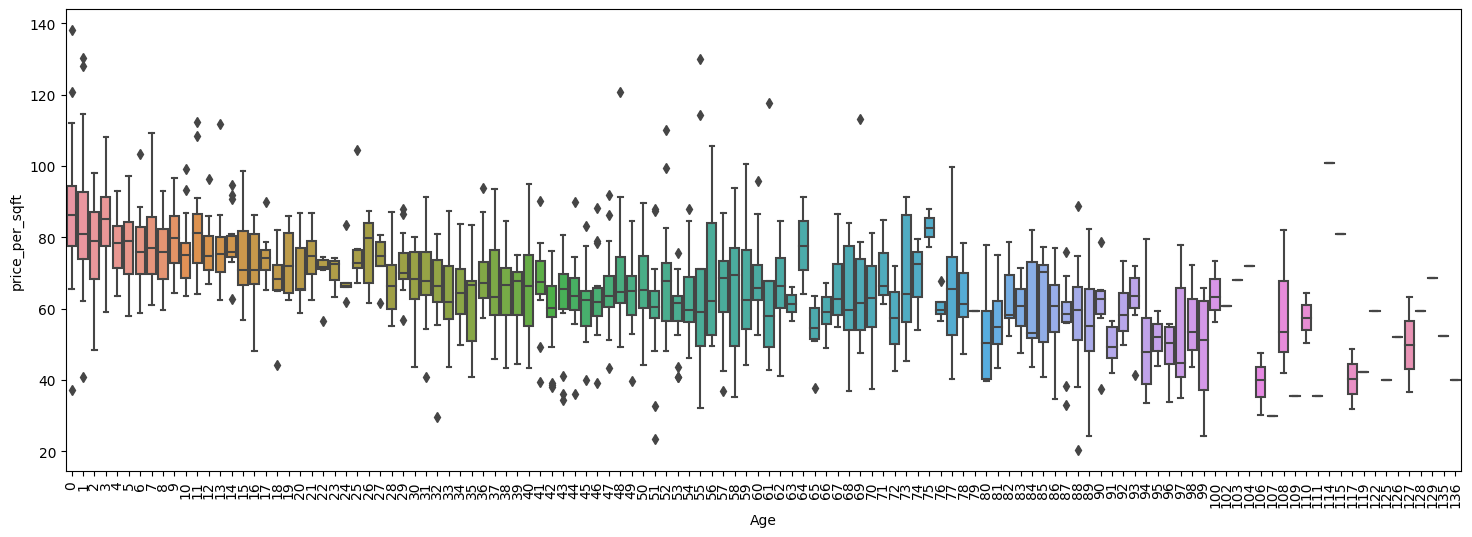

In [16]:
# Price per sq ft

var = 'YearBuilt'
var2 = 'YrSold'
df_train['Age'] = df_train[var2]-df_train[var]
data = pd.concat([df_train['price_per_sqft'], df_train['Age']], axis=1)
f, ax = plt.subplots(figsize=(18, 6))
fig = sns.boxplot(x='Age', y="price_per_sqft", data=data)
#fig.axis(ymin=0, ymax=800000)
plt.xticks(rotation = 90);

Newer houses are more expensive having high median prices vs old houses

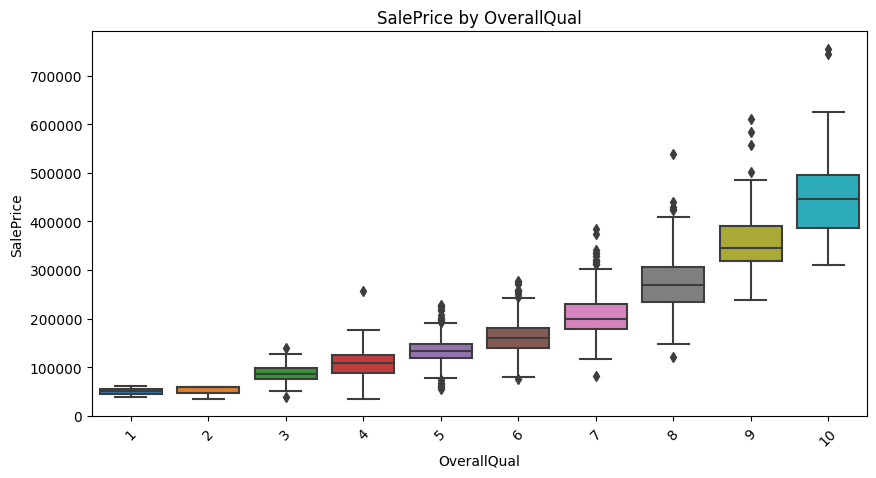

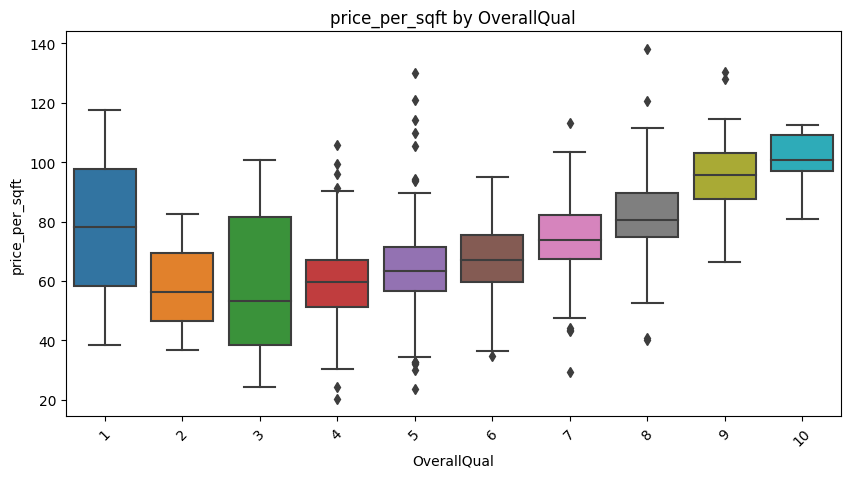

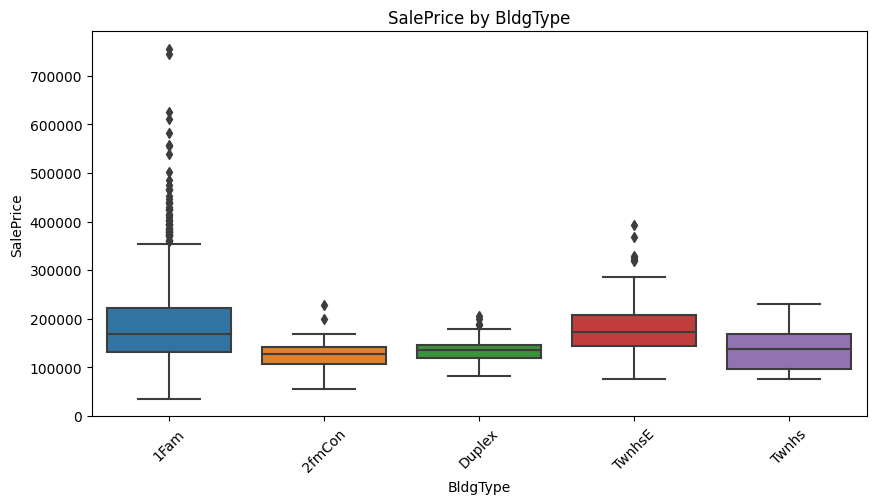

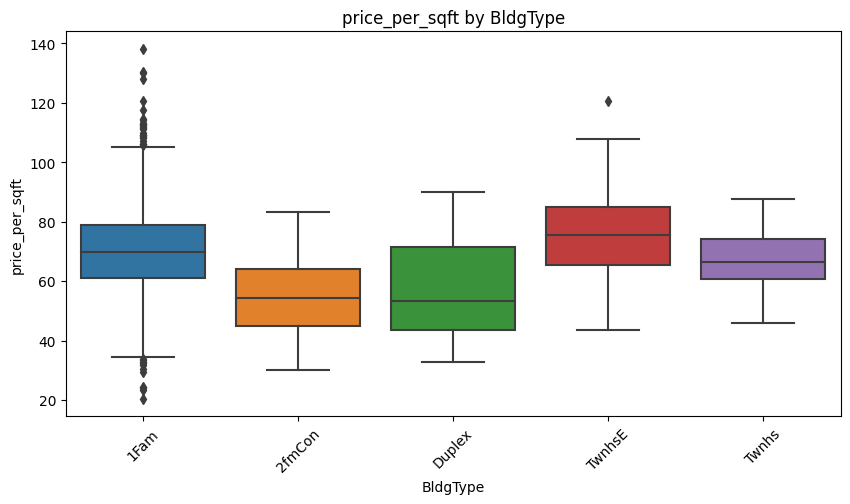

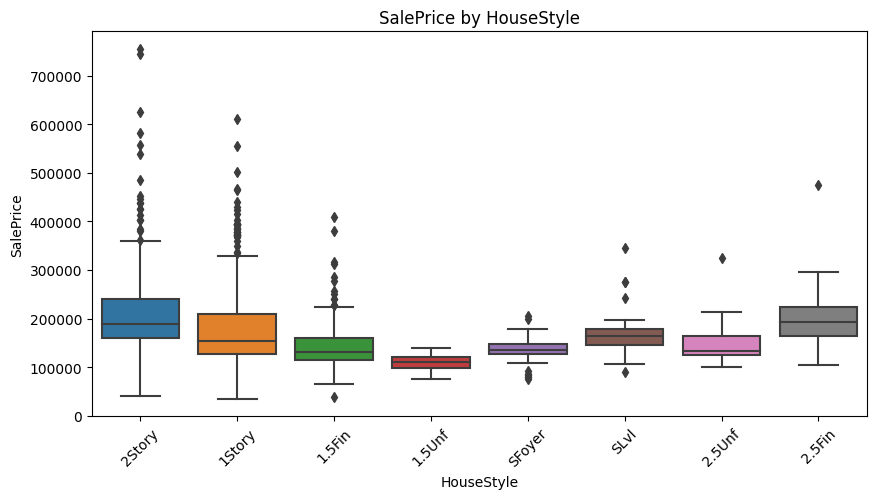

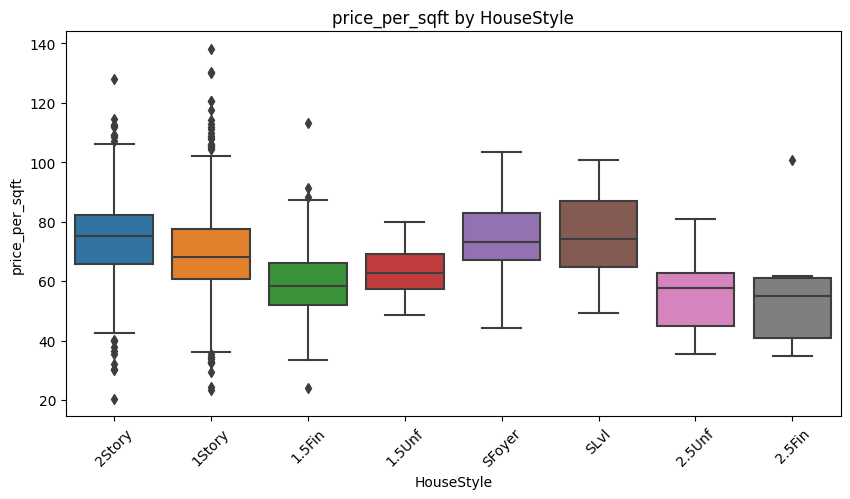

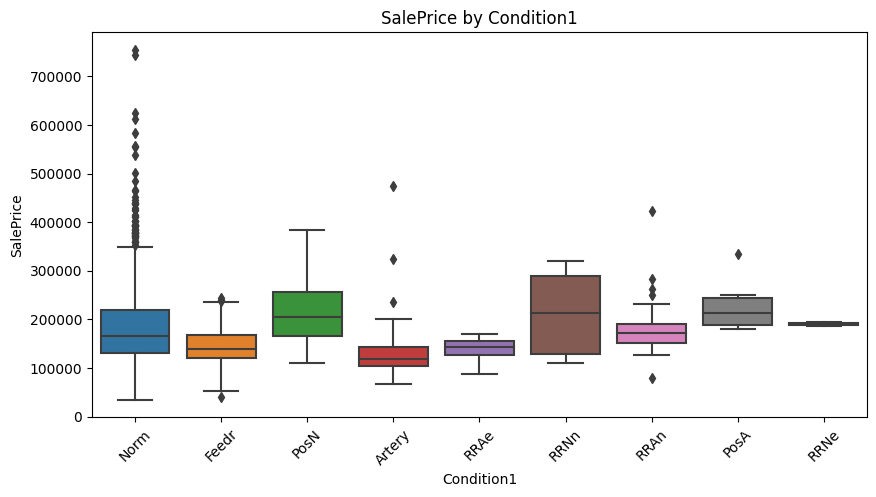

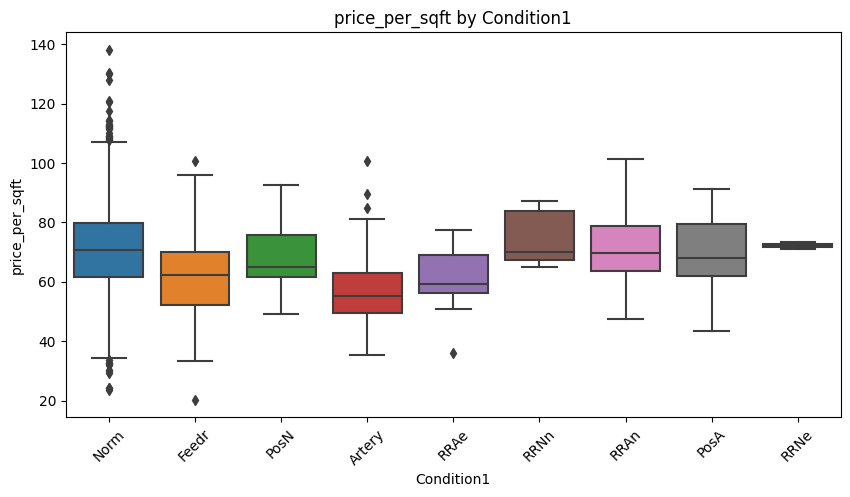

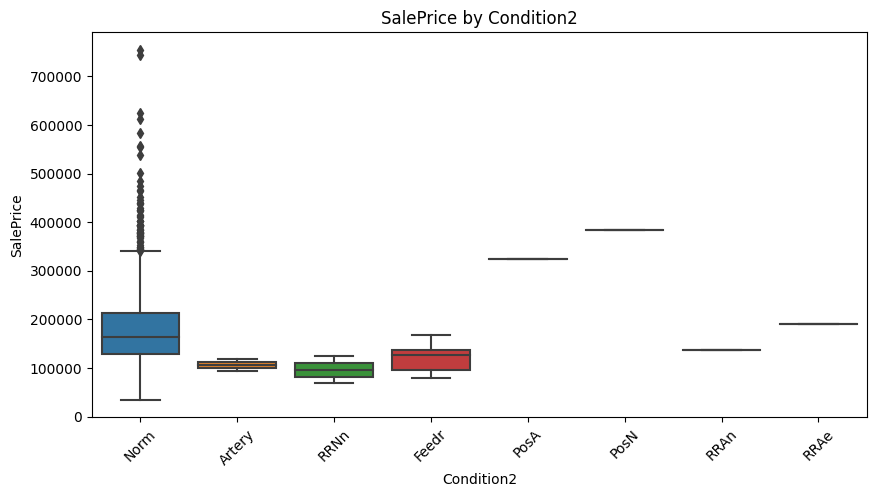

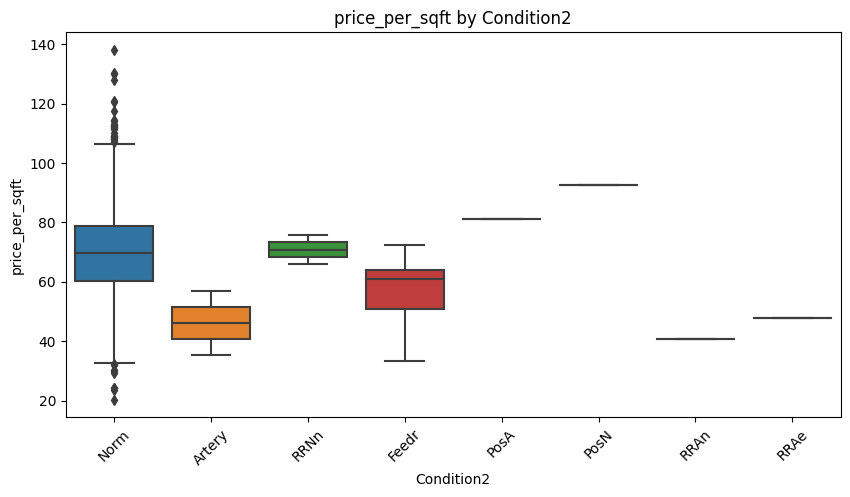

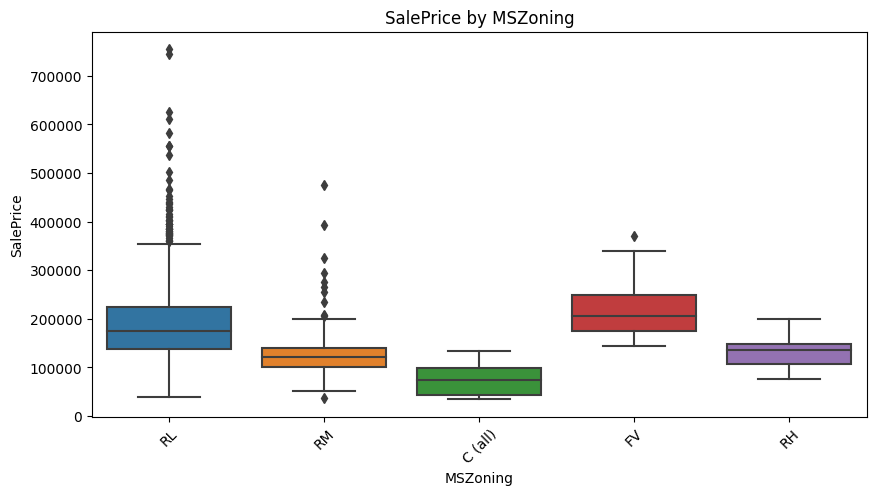

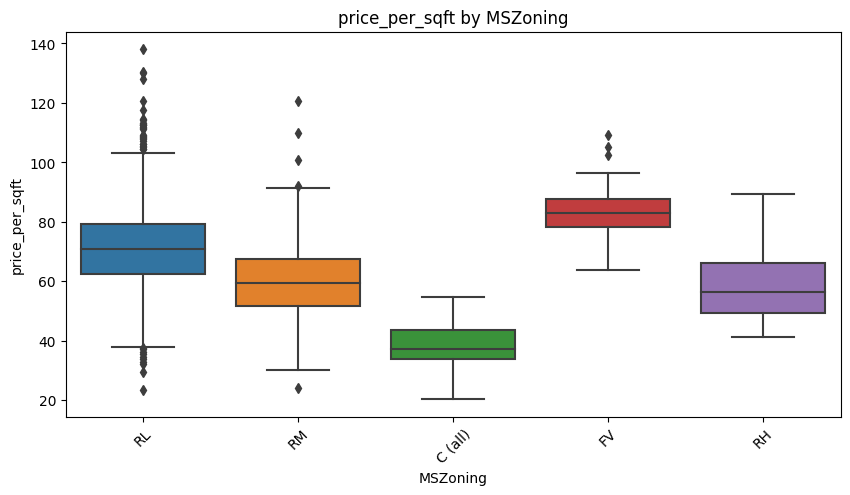

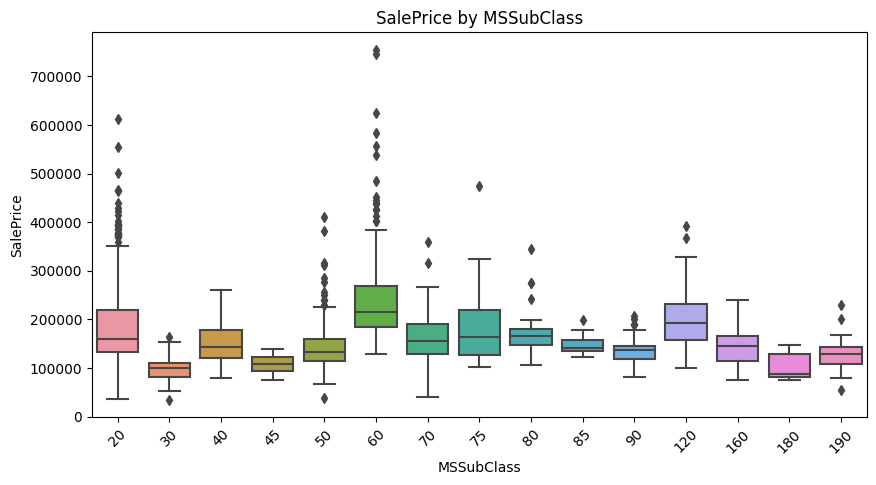

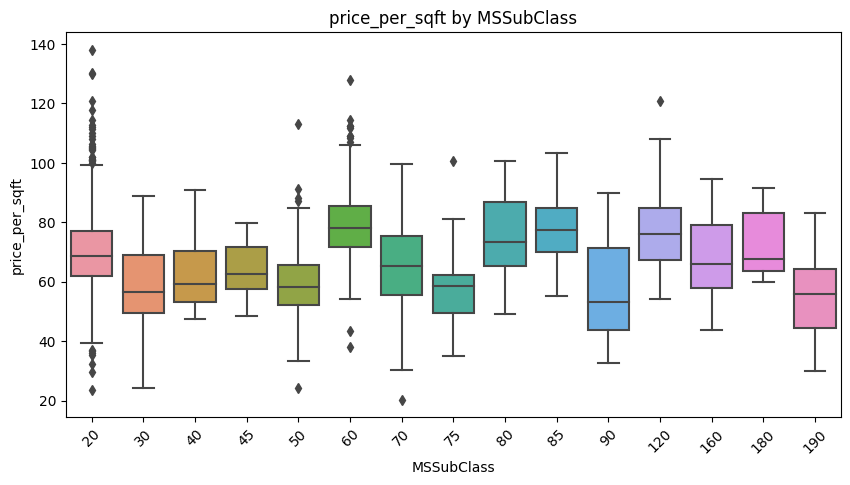

In [17]:
cat_feats = ['OverallQual','BldgType', 'HouseStyle', 'Condition1', 'Condition2', 'MSZoning', 'MSSubClass']
for col in cat_feats:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=col, y='SalePrice', data=df_train)
    plt.xticks(rotation=45)
    plt.title(f'SalePrice by {col}')
    plt.show()
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=col, y='price_per_sqft', data=df_train)
    plt.xticks(rotation=45)
    plt.title(f'price_per_sqft by {col}')
    plt.show()
   

In [18]:
df_train.groupby('OverallQual').size()

OverallQual
1       2
2       3
3      20
4     116
5     397
6     374
7     319
8     168
9      43
10     16
dtype: int64

Only 2 datapoints for overallqual 1. Hence the higher price per sqft

In [19]:
# Find missing values
#missing data
total = df_train.isnull().sum().sort_values(ascending=False)
missing_cols = total[total>0]
print(missing_cols)

PoolQC          1452
MiscFeature     1404
Alley           1367
Fence           1177
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageFinish      81
GarageCond        81
GarageYrBlt       81
GarageQual        81
GarageType        81
BsmtExposure      38
BsmtFinType2      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64


In [20]:
# Deal with missng values. Drop columns where missing values are ~50%

# Dropping cols:
# PoolQC           1453
# MiscFeature      1406
# Alley            1369
# Fence            1179
# MasVnrType        872
# FireplaceQu       690
null_cols = total[total > 600].index
print(null_cols)

Index(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType', 'FireplaceQu'], dtype='object')


In [21]:
df_train = df_train.drop(columns=null_cols)



In [22]:
total = df_train.isnull().sum().sort_values(ascending=False)
missing = total[total>0]
print(missing)

LotFrontage     259
GarageFinish     81
GarageType       81
GarageQual       81
GarageCond       81
GarageYrBlt      81
BsmtFinType2     38
BsmtExposure     38
BsmtCond         37
BsmtFinType1     37
BsmtQual         37
MasVnrArea        8
Electrical        1
dtype: int64


In [23]:
#Handle other missing values by replaceing them with median,0 or NA depending on the column

#Handle other missing values by replaceing them with median,0 or NA depending on the column

df_train.loc[:,"GarageType" ] = df_train.loc[:, "GarageType"].fillna("NA")
df_train.loc[:, "GarageFinish"] = df_train.loc[:, "GarageFinish"].fillna("NA")
df_train.loc[:, "GarageQual"] = df_train.loc[:, "GarageQual"].fillna("NA")
df_train.loc[:, "GarageCond"] = df_train.loc[:, "GarageCond"].fillna("NA")
df_train.loc[:, "BsmtQual"] = df_train.loc[:, "BsmtQual"].fillna("NA")
df_train.loc[:, "BsmtCond"] = df_train.loc[:, "BsmtCond"].fillna("NA")
df_train.loc[:, "BsmtExposure"] = df_train.loc[:, "BsmtExposure"].fillna("NA")
df_train.loc[:, "BsmtFinType1"] = df_train.loc[:, "BsmtFinType1"].fillna("NA")
df_train.loc[:, "BsmtFinType2"] = df_train.loc[:, "BsmtFinType2"].fillna("NA")



In [24]:
total = df_train.isnull().sum().sort_values(ascending=False)
missing = total[total>0]
print(missing)

LotFrontage    259
GarageYrBlt     81
MasVnrArea       8
Electrical       1
dtype: int64


In [25]:

num_cols = ['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

for col in num_cols:
    df_train[col].fillna(df_train[col].median(), inplace=True)

    

In [26]:
df_train = df_train[df_train['Electrical'].notnull()]
total = df_train.isnull().sum().sort_values(ascending=False)
missing = total[total>0]
print(missing)

Series([], dtype: int64)


In [27]:
# # Deep Dive into categorical features. Which are low cardinality vs high cardinality so we can manioulate them aaccordingly

# cat_cols = df_train.select_dtypes(include='object').columns.tolist()
# unique_counts = [(col, df_train[col].nunique()) for col in cat_cols]

# # Sort the list by unique_count in descending order
# unique_counts_sorted = sorted(unique_counts, key=lambda x: x[1], reverse=True)

# # Print the sorted results
# for col, count in unique_counts_sorted:
#     print(f"{col}: {count} unique values")

### Feature Engineering

### Skewness Analysis 

In [28]:
from scipy.stats import boxcox

# --- Drop highly skewed, sparse columns ---
drop_cols = [ '3SsnPorch', 'LowQualFinSF','MiscVal', 'PoolArea']
df_train.drop(columns=drop_cols, inplace=True)

# --- Log transform columns ---
log_cols = ['1stFlrSF', '2ndFlrSF', 'GrLivArea', 'LotArea', 'MSSubClass', 
            'MasVnrArea', 'OpenPorchSF', 'SalePrice', 'WoodDeckSF'
           ,'BsmtFinSF2', 'BsmtHalfBath', 'EnclosedPorch', 'ScreenPorch']
for col in log_cols:
    df_train[col] = np.log1p(df_train[col])  # log1p = log(x + 1)


# --- Box-Cox transformation  ---
boxcox_cols = ['BsmtFinSF1', 'TotalBsmtSF', 'BsmtUnfSF']
for col in boxcox_cols:
    df_train[col], _ = boxcox(df_train[col] + 1)  # shift if zeros are present

# --- Convert to categorical ---
df_train['KitchenAbvGr'] = df_train['KitchenAbvGr'].astype(str)



In [29]:
from scipy.stats import skew

numerical_features = df_train.select_dtypes(exclude = ["object"]).columns
skewness = df_train[numerical_features].apply(lambda x: skew(x))
print(skewness.sort_values(ascending = False))

BsmtHalfBath      3.924
ScreenPorch       3.143
BsmtFinSF2        2.517
EnclosedPorch     2.107
LotFrontage       1.719
OverallCond       0.689
HalfBath          0.681
TotRmsAbvGrd      0.660
Fireplaces        0.630
Age               0.607
BsmtFullBath      0.589
MasVnrArea        0.505
2ndFlrSF          0.294
MSSubClass        0.252
price_per_sqft    0.227
MoSold            0.214
BedroomAbvGr      0.212
OverallQual       0.199
WoodDeckSF        0.158
GarageArea        0.131
SalePrice         0.121
YrSold            0.096
FullBath          0.033
1stFlrSF          0.006
Id                0.001
OpenPorchSF      -0.024
TotalBsmtSF      -0.030
GrLivArea        -0.071
LotArea          -0.181
BsmtUnfSF        -0.275
GarageCars       -0.341
BsmtFinSF1       -0.418
YearRemodAdd     -0.500
YearBuilt        -0.611
GarageYrBlt      -0.676
dtype: float64


In [30]:
from sklearn.preprocessing import OrdinalEncoder
# Ordinal encoding for ranked categories

ordinal_cols1 = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond','HeatingQC','KitchenQual','GarageQual','GarageCond']
ordinal_map1 = {'No':0,'NA':0,'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}

for col in ordinal_cols1:
    df_train[col] = df_train[col].map(ordinal_map1)


In [31]:
total = df_train.isnull().sum().sort_values(ascending=False)
missing = total[total>0]
print(missing)

Series([], dtype: int64)


In [32]:
df_train = df_train.replace({"Alley" : {"Grvl" : 1, "Pave" : 2},
                       "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4,"ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, "ALQ" : 5, "GLQ" : 6},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2},
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}
                        })
        

In [33]:
#Transforming numerical into categorical features.
df_train['MSSubClass'] = df_train['MSSubClass'].apply(str)
# df_train['YrSold'] = df_train['YrSold'].astype(str)
df_train['MoSold'] = df_train['MoSold'].astype(str)

In [34]:
# Creating binary feature for remodeled
df_train['WasRemodeled'] = (df_train['YearBuilt'] != df_train['YearRemodAdd']).astype(int)
df_train['RemodAge'] = df_train['YrSold'] - df_train['YearRemodAdd']

In [35]:
df_train.drop(['YearBuilt', 'YearRemodAdd', 'YrSold'], axis=1, inplace=True)

### Correlation Analysis and checking for multicollinearity

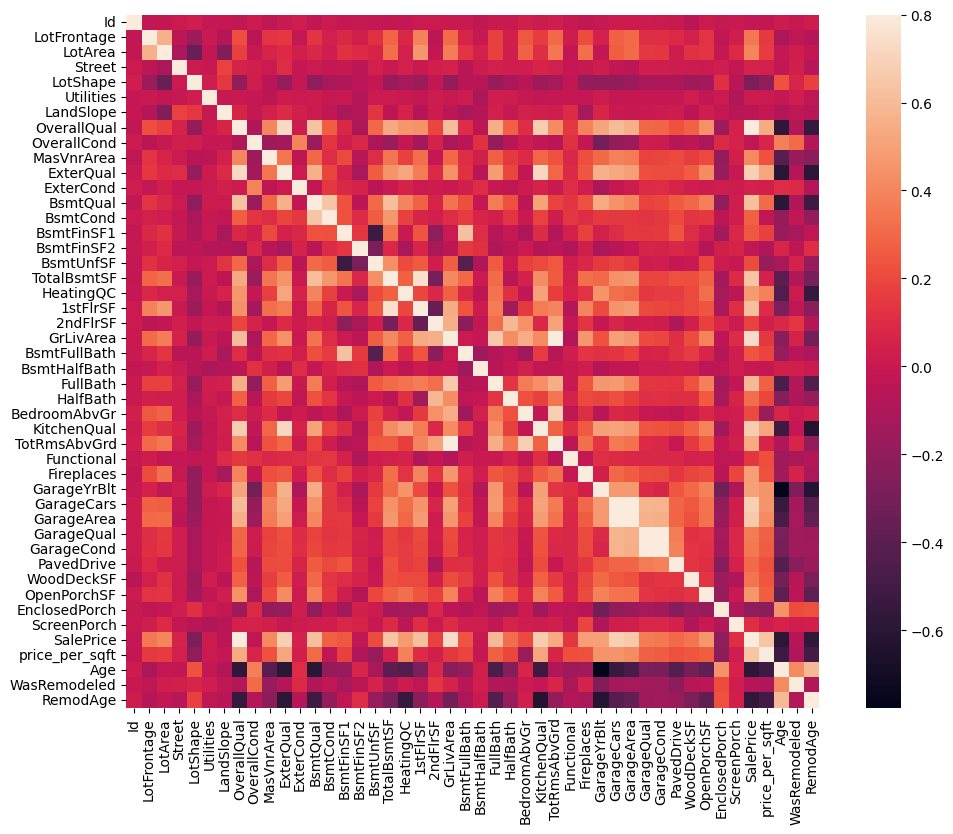

In [36]:
#correlation matrix
corrmat = df_train.select_dtypes(include='number').corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

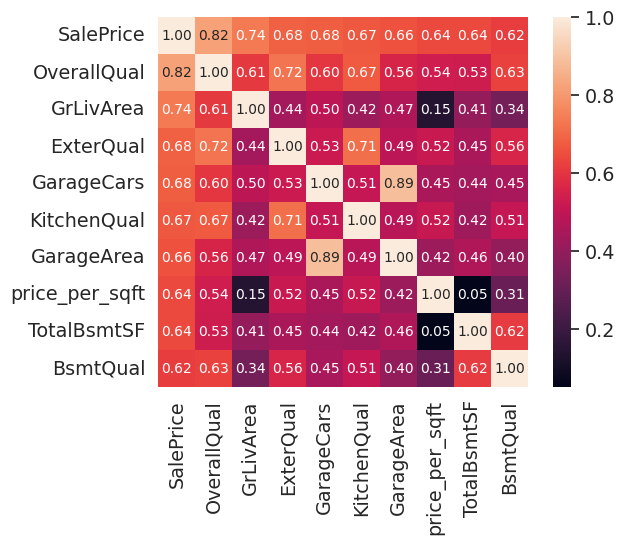

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'ExterQual', 'GarageCars',
       'KitchenQual', 'GarageArea', 'price_per_sqft', 'TotalBsmtSF',
       'BsmtQual'],
      dtype='object')


In [37]:
# Correlation matrix for 10 features having highest correlation
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()
print(cols)

In [38]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
X = df_train[['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd']]  # example features

# 2. Add constant for intercept
X_const = add_constant(X)

# 3. Compute VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X_const.columns
vif_data['VIF'] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

print(vif_data)

        Feature      VIF
0         const 2064.230
1   OverallQual    2.340
2     GrLivArea    4.929
3    GarageCars    5.248
4    GarageArea    4.933
5   TotalBsmtSF    2.725
6      1stFlrSF    2.834
7      FullBath    1.922
8  TotRmsAbvGrd    3.256


In [39]:
# One Hot endocing

one_hot_cols = [
    'MSZoning', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2',
    'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
    'Exterior2nd', 'Foundation', 'Heating', 'CentralAir',
    'Electrical', 'GarageType', 'SaleType', 'SaleCondition','LandContour','GarageFinish'
]


df_train = pd.get_dummies(df_train, columns=one_hot_cols, drop_first=True)


In [40]:
one_hot_cols_2 = ['MSSubClass','BsmtExposure','BsmtFinType1','BsmtFinType2','KitchenAbvGr',
                 'MoSold']

df_train = pd.get_dummies(df_train, columns=one_hot_cols_2, drop_first=True)


In [41]:
# Check missing
total = df_train.isnull().sum().sort_values(ascending=False)
missing = total[total>0]
print(missing)

Series([], dtype: int64)


In [42]:
# #scatterplot : What do these mean  ???? Maybe delete
# sns.set()
# cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt'] # cols is my feature list
# sns.pairplot(df_train[cols], size = 2.5)
# plt.show();

In [43]:
### ------------------------------------------BREAK START------------------------------------

In [44]:
# sns.set()
# cols = ['SalePrice_log', 'GrLivArea','GarageCars','TotalBsmtSF']#'OverallQual', 'GrLivArea',  'FullBath', 'YearBuilt']
# sns.pairplot(df_train[cols], size = 2.5)
# plt.show();

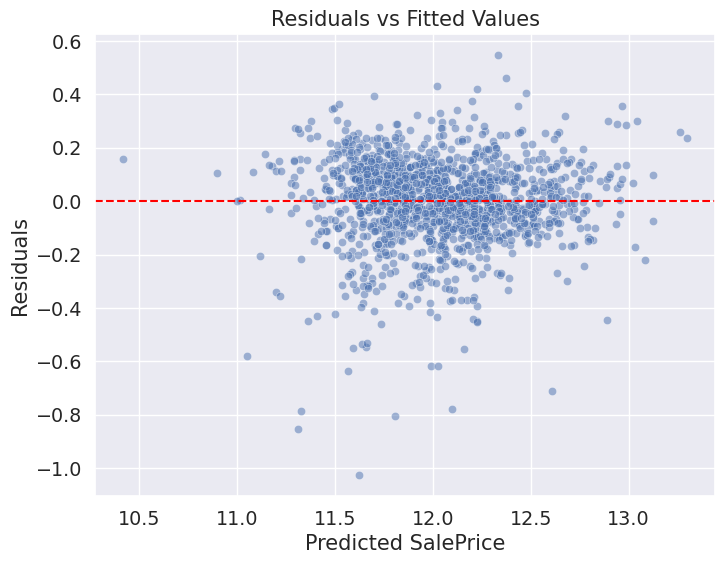

In [45]:
# Checking for Homoskedasticity
from sklearn.linear_model import LinearRegression


feature_list = ['OverallQual', 'GrLivArea', 'ExterQual', 'GarageCars',
       'KitchenQual', 'GarageArea', 'TotalBsmtSF','BsmtQual']
X = df_train[feature_list]  # your selected features
y = df_train['SalePrice']
model = LinearRegression().fit(X, y)
y_pred = model.predict(X)
residuals = y - y_pred

# Plot residuals vs predictions
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted SalePrice")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.show()

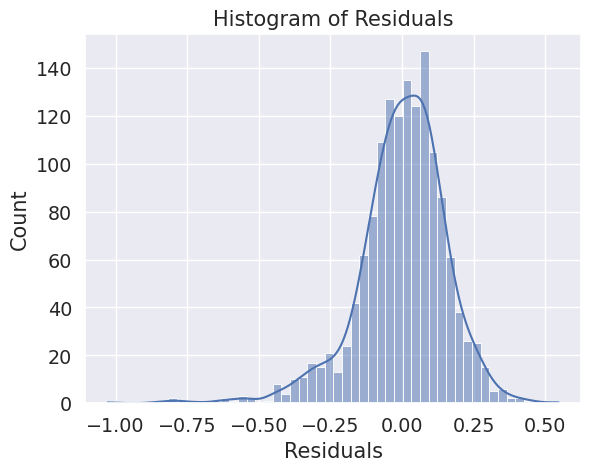

In [46]:
# histplot to check if they are normally distrbuted

sns.histplot(residuals, kde=True)
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.show()

In [47]:
from scipy.stats import shapiro

stat, p = shapiro(residuals)
print(f"Shapiro-Wilk p-value: {p}")

Shapiro-Wilk p-value: 7.79504364284523e-23


The p-value pess than 0.05 indicates some skewness. 

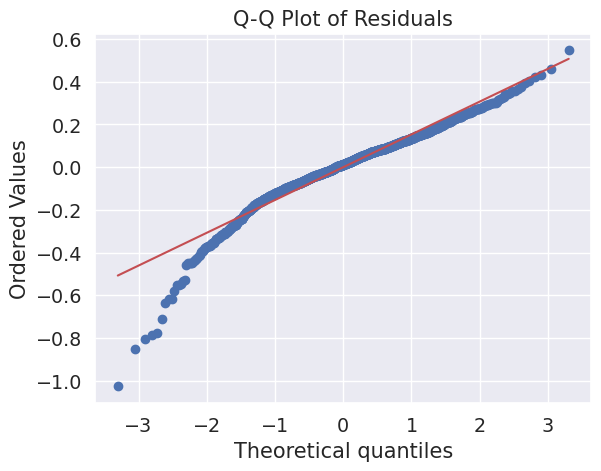

In [48]:

stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

Checking skewness in some variables

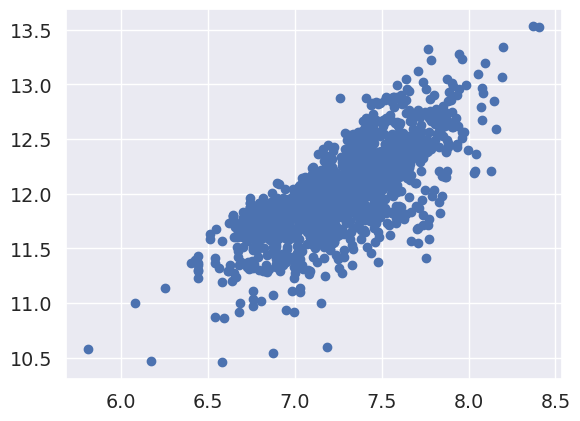

In [49]:
plt.scatter(df_train['GrLivArea'], df_train['SalePrice']);

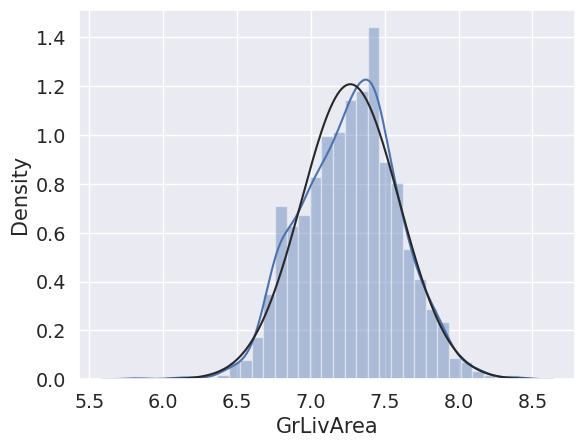

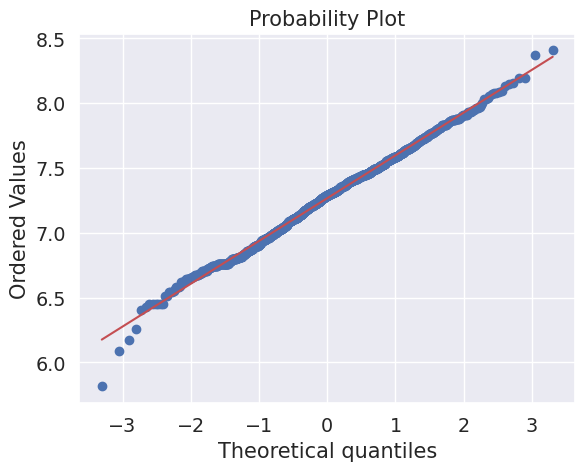

In [50]:
sns.distplot(df_train['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['GrLivArea'], plot=plt)

In [51]:
# # Applying transformation to GrLivArea since the normal distribution plot is indicating skewness

# df_train['GrLivArea'] = np.log(df_train['GrLivArea'])


Checked for normality and skewness again and now its much better



In [52]:
# Handling outliers for TotalBsmtSF and handling 0 values


# df_train['HasBsmt'] = pd.Series(len(df_train['TotalBsmtSF']), index=df_train.index)
# df_train['HasBsmt'] = 0 
# df_train.loc[df_train['TotalBsmtSF']>0,'HasBsmt'] = 1
# df_train.loc[df_train['HasBsmt']==1,'TotalBsmtSF'] = np.log(df_train['TotalBsmtSF'])

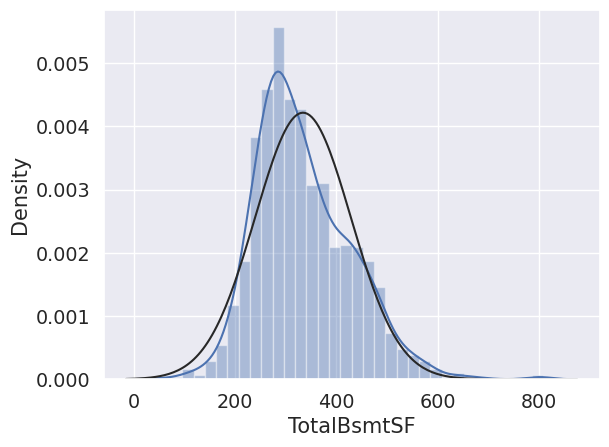

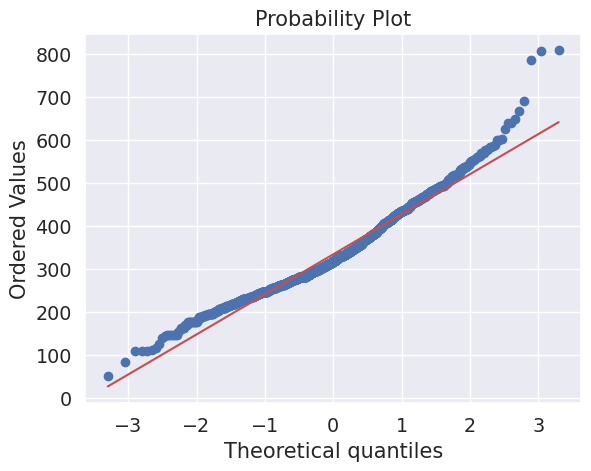

In [53]:
sns.distplot(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], plot=plt)


The histogram appears to be normally distributed. The Q-Q plot below compares the log-transformed quantiles against theoretical normal distribution. Since majority of points lie close to the red line it indicates that the data follows a normal distribtuion with some deviations at the tails.

In [54]:
#X and y
y = df_train['SalePrice']
X = df_train.drop(columns = ['price_per_sqft','SalePrice'])


Scale only X not y since its already log transformed

In [55]:
# Commenting this section to scale X after splitting. To be confirmed

# pd.set_option('display.max_rows', None)   # Show all rows
# numerical_features = X.select_dtypes(exclude = ["object"]).columns
# stdSc = StandardScaler()
# X.loc[:, numerical_features] = stdSc.fit_transform(X.loc[:, numerical_features])


In [56]:
# y = df_train['SalePrice_log']
# X = df_train.drop(columns = ['SalePrice_log','price_per_sqft','SalePrice'])

from sklearn.model_selection import train_test_split

#split the data using sklearn routine 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30, random_state=1)
# X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.50, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
# print("X_cv.shape", X_cv.shape, "y_cv.shape", y_cv.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

X_train.shape (1019, 226) y_train.shape (1019,)
X_test.shape (438, 226) y_test.shape (438,)


In [57]:
X.dtypes


Id                                 int64
LotFrontage                      float64
LotArea                          float64
Street                             int64
LotShape                           int64
Utilities                          int64
LandSlope                          int64
OverallQual                        int64
OverallCond                        int64
MasVnrArea                       float64
ExterQual                          int64
ExterCond                          int64
BsmtQual                           int64
BsmtCond                           int64
BsmtFinSF1                       float64
BsmtFinSF2                       float64
BsmtUnfSF                        float64
TotalBsmtSF                      float64
HeatingQC                          int64
1stFlrSF                         float64
2ndFlrSF                         float64
GrLivArea                        float64
BsmtFullBath                       int64
BsmtHalfBath                     float64
FullBath        

In [58]:
from sklearn import model_selection
from sklearn.model_selection import cross_val_score

scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)


model = LinearRegression()
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

In [59]:
rmse_scores = (-scores) ** 0.5
print("RMSE for each fold:", rmse_scores)
print("Mean RMSE:", np.mean(rmse_scores))


RMSE for each fold: [0.12485614 0.12648768 0.12506987 0.12285873 0.11330854]
Mean RMSE: 0.12251619214598948


In [60]:

scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
scores

array([0.89897963, 0.89437274, 0.91355198, 0.91136299, 0.9157732 ])

Pretty high r-squared and low RMSE

In [61]:
from sklearn.metrics import mean_squared_error


model.fit(X_train, y_train)

log_preds = model.predict(X_test)
# log_preds = np.clip(log_preds, a_min=None, a_max=20)  # log(5M)

# print(log_preds,y_test)
# RMSE on log scale
rmse_log = mean_squared_error(y_test, log_preds, squared=False)

# # Convert back to original scale
y_test_actual = np.expm1(y_test)
y_pred_actual = np.expm1(log_preds)

# # # RMSE on actual price scale
print("Log Test RMSE:", rmse_log)



Log Test RMSE: 0.13491020154211136


#### ---------------------------------Visualizing Predicted values---------------------------

In [62]:
log_preds_series = pd.Series(log_preds, index=y_test.index)
df_compare = pd.concat([
    y_test.sort_values(ascending=False).reset_index(drop=True),
    log_preds_series.sort_values().reset_index(drop=True)
], axis=1)

df_compare.columns = ['Actual (log)', 'Predicted (log)']
print(df_compare.head())

   Actual (log)  Predicted (log)
0        13.196           10.580
1        13.053           10.822
2        12.992           10.985
3        12.972           11.070
4        12.960           11.092


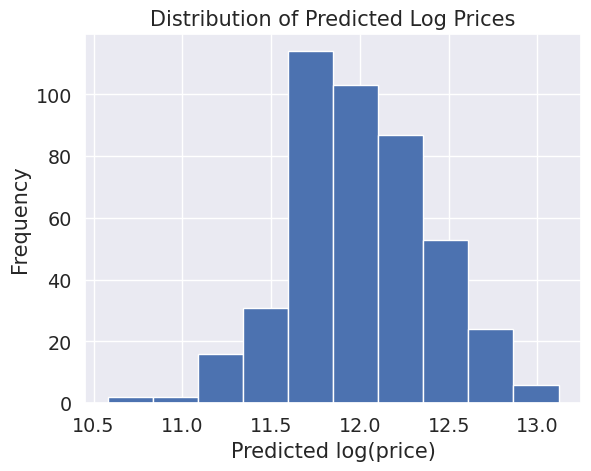

In [63]:
plt.hist(log_preds)
plt.title("Distribution of Predicted Log Prices")
plt.xlabel("Predicted log(price)")
plt.ylabel("Frequency")
plt.show()

#### -----------------------------------------------------------------------------------------

In [64]:
y_pred_log = (log_preds)
# # y_test.head(10)
rmse_actual= mean_squared_error(y_test_actual, y_pred_actual, squared=False)
print("Test RMSE:", (rmse_actual))
print("Max value:", np.max(y_pred_log))
print("Min value:", np.min(y_pred_log))

# Count how many values are very large (e.g., > 100)
# print("Predictions > 100:", np.sum(y_pred_log > 100))
# print("Predictions > 700:", np.sum(y_pred_log > 700))  # This will overflow on exp()

# You can also print these actual values
# print("Large predictions:\n", y_pred_log[y_pred_log > 100])


Test RMSE: 21561.70005479961
Max value: 13.119159272633176
Min value: 10.579624639873462


In [65]:
print(np.any(np.isinf(y)), np.any(np.isnan(y)))  # should both be False

# Check X
X = X.apply(pd.to_numeric, errors='coerce')

print(np.any(np.isinf(X)), np.any(np.isnan(X)))  # Should also be False

False False
False False


During cross-validation, the model showed decent performance — an RMSE of around 29% and an R² of 90% on the training set. However, when I tried to evaluate the model on the test set, I ran into a major issue: several predictions in the log(y) space were either extremely large or even inf, which made it impossible to properly compute the final RMSE or recover the original price values using np.exp().

### 🕵️ Step-by-Step Debugging
At first, I suspected a data-related issue, so I began tracing the transformations. I realized that I had applied a StandardScaler after applying np.log() to the target variable y. 
This meant the model was learning to predict scaled log-values, not pure log-prices — but I was applying np.exp() on those predictions as if they were raw logs, which caused overflow and returned inf.

I corrected this by removing StandardScaler from the target transformation pipeline. Now, y was transformed using only np.log1p(), and inverse-transformed using np.expm1() after prediction — no scaling involved.

### 🔍 More Issues Found
Despite that fix, some predictions were still suspiciously large (e.g., 70 million in log space). 
So, I dug deeper. I printed the max and min values of y_pred_log and discovered several outputs well beyond the range of realistic log(price) values (which should typically be between 10 and 15). Some were over 100 million.
This suggested that the model was extrapolating wildly — possibly due to:
    
* Large or unscaled features in X
* Outliers in the training data
* Correlated features affecting the coefficients

<!-- I checked X_test.describe() and confirmed that a few numeric features had extremely large values (like square footage or year built) that weren’t scaled. Since linear models are sensitive to feature scale, I added a StandardScaler to the feature pipeline — this immediately stabilized the predictions. -->Can deep dive into this later. Applying risge/lasso for now

### 💡 Key Takeaways

* Always inverse-transform predictions in the same order as preprocessing.
* Don’t scale the target unless absolutely necessary — and never forget to reverse it if you do.
* For log-transformed targets, use np.log1p() and np.expm1() to handle zeros safely.Validate intermediate outputs like y_pred_log.max() to catch anomalies early.


In [67]:
## Applying regularization

from sklearn.linear_model import Ridge, Lasso
X_test_scaled = X_test



In [69]:


# Try different alpha values
alpha_values = [0.01, 0.1, 1, 10, 100]

print("---- Ridge Results ----")
for alpha in alpha_values:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_test)
    
    # RSE: sqrt(Sum of Squares of Residuals / degrees of freedom)
    rss = np.sum((y_test - y_pred) ** 2)
    rse = np.sqrt(rss / (len(y_test) - X_test.shape[1] - 1))  # df = n - p - 1
    
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print(f"Alpha: {alpha:>5} | R^2: {ridge.score(X_test, y_test):.4f} | RMSE: {rmse:.4f} | RSE: {rse:.4f}")

    
print("\n---- Lasso Results ----")
for alpha in alpha_values:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_train, y_train)
    y_pred = lasso.predict(X_test)
    
    rss = np.sum((y_test - y_pred) ** 2)
    rse = np.sqrt(rss / (len(y_test) - X_test.shape[1] - 1))
    
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print(f"Alpha: {alpha:>5} | R^2: {ridge.score(X_test, y_test):.4f} | RMSE: {rmse:.4f} | RSE: {rse:.4f}")

    

---- Ridge Results ----
Alpha:  0.01 | R^2: 0.8830 | RMSE: 0.1335 | RSE: 0.1924
Alpha:   0.1 | R^2: 0.8897 | RMSE: 0.1296 | RSE: 0.1868
Alpha:     1 | R^2: 0.8971 | RMSE: 0.1253 | RSE: 0.1805
Alpha:    10 | R^2: 0.8998 | RMSE: 0.1236 | RSE: 0.1781
Alpha:   100 | R^2: 0.8904 | RMSE: 0.1292 | RSE: 0.1862

---- Lasso Results ----
Alpha:  0.01 | R^2: 0.8904 | RMSE: 0.1427 | RSE: 0.2056
Alpha:   0.1 | R^2: 0.8904 | RMSE: 0.1921 | RSE: 0.2768
Alpha:     1 | R^2: 0.8904 | RMSE: 0.2348 | RSE: 0.3383
Alpha:    10 | R^2: 0.8904 | RMSE: 0.2688 | RSE: 0.3872
Alpha:   100 | R^2: 0.8904 | RMSE: 0.3909 | RSE: 0.5632


Test RMSE was in initially comparing absolute sale price and log of sale price